# Anomaly Detection in Financial Time Series

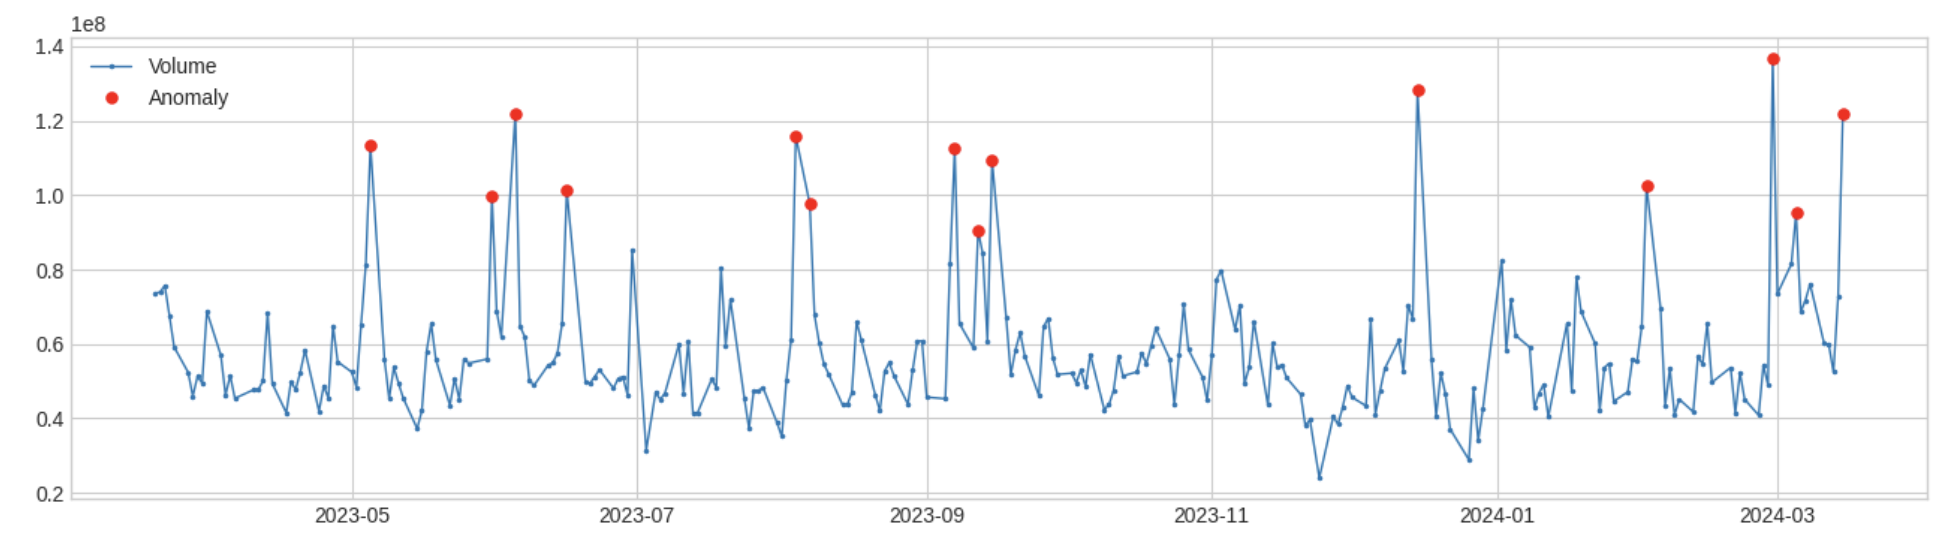

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**


## Content
In this module we will be looking at different statistical models and tools that can be used to analyze time series data. We will cover how to load csv files that contain time series data, in this example we will be looking at the price and volume data over a year for Apple stock, and how to implement robust solutions for the detection of anomalies. Though this module serves as a primer, the tools discussed here are easily translatable to other time series pertinent to supervision such as anti-money laundering and identifying fraudulent transactions.

## Defining our target

Detecting Anomalies in Financial Time Series Data

Models/Methods: Interquartile Range, Generalized ESD Test, Clustering, Regression, Volatility, Sliding Windows

Note: Though this module serves as a primer, the tools discussed here are easily translatable to other time series pertinent to supervision such as anti-money laundering and identifying fraudulent transactions.

## Loading and storing time series data from CSV files

Firstly we will import the stock data for Apple from 03/20/2023 - 03/15/2024 and store it as a Pandas Dataframe object. Let us import some required libraries for this task

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from assets.getting_started import connect_to_database

Next lets extract the data and store it

In [2]:
c = connect_to_database()
q = """
  SELECT *
  FROM datagymnasium."aapl_price"
"""
c.execute(q)
cols = [desc[0] for desc in c.description]
df = pd.DataFrame(c.fetchall(), columns=cols)
df['Date'] = pd.to_datetime(df['Date'])
convert_dict = {
    'Open': float,
    'High': float,
    'Low': float,
    'Close': float,
    'Adj Close': float,
    'Volume': int
}
df = df.astype(convert_dict)
df.set_index('Date', inplace=True)

**Note:** You can ignore the warning. The data is now stored in pandas dataframe object in the below way

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-20,155.070007,157.820007,154.149994,157.399994,156.564301,73641400
2023-03-21,157.320007,159.399994,156.539993,159.279999,158.434326,73938300
2023-03-22,159.300003,162.139999,157.809998,157.830002,156.992020,75701800
2023-03-23,158.830002,161.550003,157.679993,158.929993,158.086182,67622100
2023-03-24,158.860001,160.339996,157.850006,160.250000,159.399170,59196500
...,...,...,...,...,...,...
2024-03-11,172.940002,174.380005,172.050003,172.750000,172.750000,60139500
2024-03-12,173.149994,174.029999,171.009995,173.229996,173.229996,59825400
2024-03-13,172.770004,173.190002,170.759995,171.130005,171.130005,52488700


As you can see the data consists of 250 rows and 6 columns with the main index column now set as the date

## Anomaly Detection Toolkit (ADTK) – Installation, Validation and Visualization

Next we will install the Anomaly Detection Toolkit (ADTK) and learn how to validate and visualize the data

In [4]:
!pip install -qq adtk

Next we will use the ADTK toolkit to validate the imported data to ensure there are no missing values or errors

In [5]:
import adtk
from adtk.data import validate_series
validate_df = validate_series(df)

We will then split the dataframe into 2 different ones. Specifically, we will analyze the closing stock price and volume data

In [6]:
df_closing = df['Close']
df_volume = df['Volume']

Next we plot and visualize these 2 separate time series


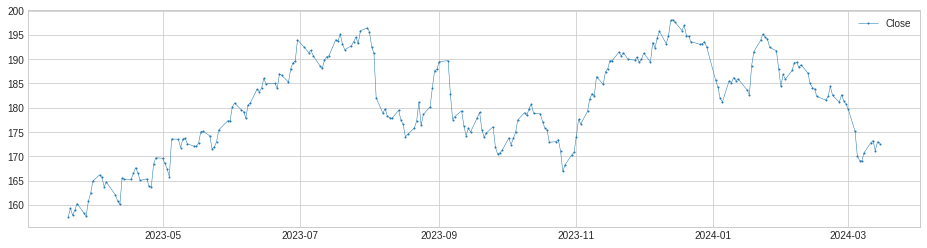

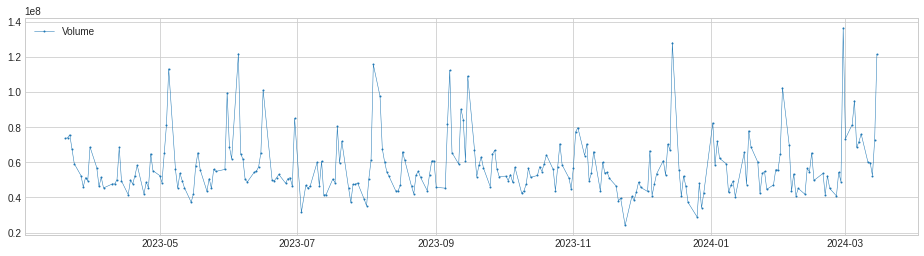

In [7]:
from adtk.visualization import plot
plot(df_closing)
plt.show()
plot(df_volume)
plt.show()

## Single Time Series

### Setting thresholds and quantile ranges

The simplest test we can first execute is to use a threshold value to see on which days the stock went above or below a certain price

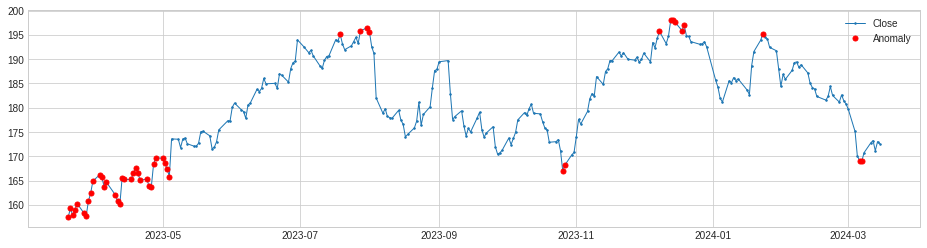

In [8]:
from adtk.detector import ThresholdAD
threshold_ad = ThresholdAD(high=195, low=170) #the high and low values of the threshold can bet set here
anomalies = threshold_ad.detect(df_closing)
#next we plot the results of the threshold analysis. The Anomalies are marked in red
plot(df_closing, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
plt.show()

We can also use quantiles to tag data points as anomalous

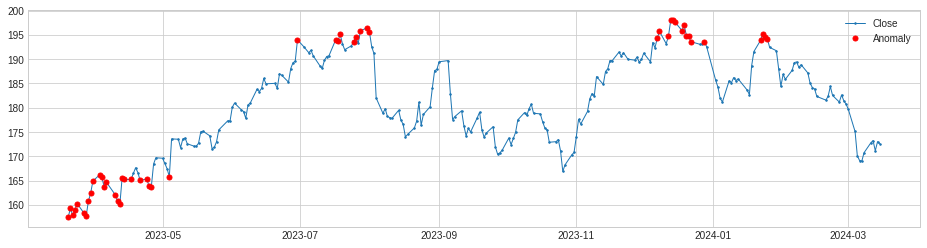

In [9]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.9, low=0.1) #sets the range of the quantiles
anomalies = quantile_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
plt.show()

We can also utilize the inter quantile range to tag data points as anomalous. Lets do this for the daily trading volume


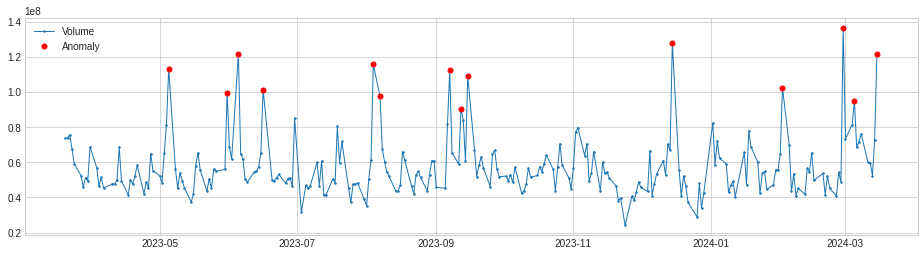

In [10]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
plt.show()

### The generalized ESD test

These are very simple statistical test to identify anomalies in time series data. Next we will move on to more sophisticated models. Starting with the generalized ESD test which uses the student's T-Distribution. One caveat to keep in mind is that this text assumes the data is normally distributed, which is often not the case for stock price data but normally true for trading volume data, since it is more stable than the pricing. Lets us use ESD test on the both the stock price and volume data

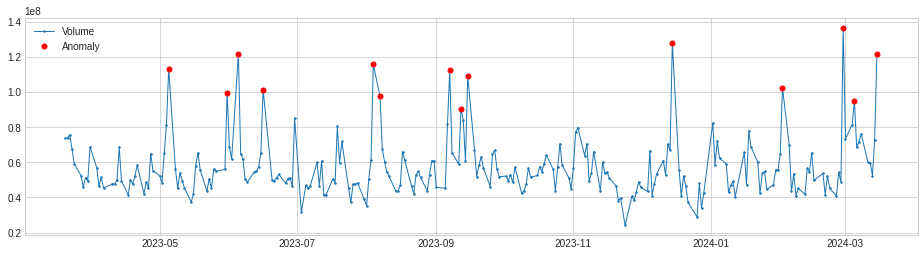

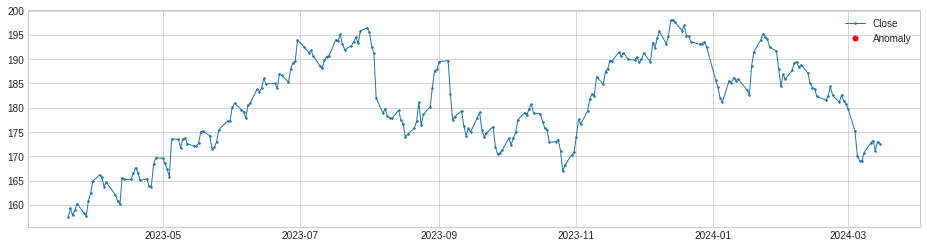

In [11]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=0.3) #Decreasing the alpha lowers the sensitivity and vice versa
anomalies = esd_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
plt.show()
esd_ad = GeneralizedESDTestAD(alpha=0.3) #Decreasing the alpha lowers the sensitivity and vice versa
anomalies = esd_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
plt.show()

As you can observe the ESD test is effective at identifying large anomalous spikes in trading volume but not in the stock price. This is because the test assumes that the data is normally distributed, thus is relatively stable with occasional spikes or drops, which is not the case for the stock price data. Decreasing the alpha lowers the sensitivity of the test and results in fewer points being tagged as anomalous

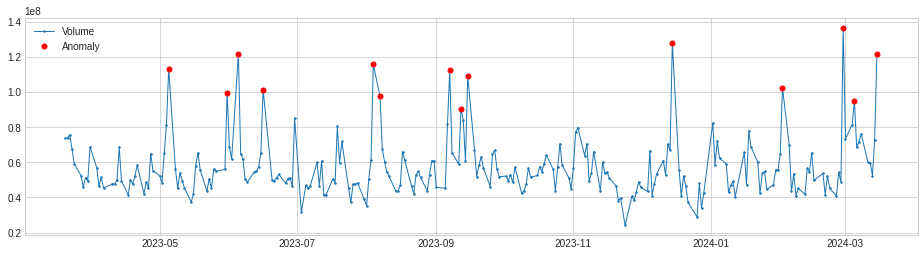

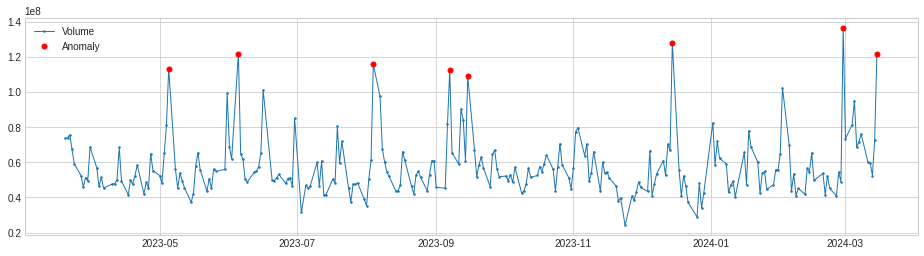

In [12]:
esd_ad = GeneralizedESDTestAD(alpha=0.3) #Decreasing the alpha lowers the sensitivity and vice versa
anomalies = esd_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
plt.show()
esd_ad = GeneralizedESDTestAD(alpha=0.01) #Decreasing the alpha lowers the sensitivity
anomalies = esd_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
plt.show()

The difference from the changing the alpha is more pronounced the closer the data follows a normal distribution


### PersistAD

Next we will utilize a model that uses a double rolling aggregate called PersistAD. This model directly compares each time series value with its previous values.
We will first use this to identify large positive changes in stock price

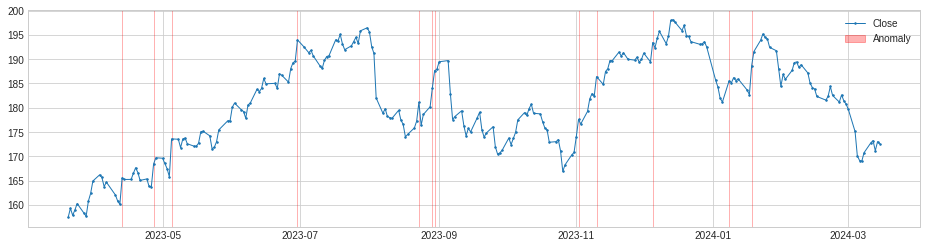

In [13]:
from adtk.detector import PersistAD
persist_ad = PersistAD(c=1.0, side='positive') #side can be positive or negative. Increasing c, which is the threshold# will result in fewer points being identified as anamolous
anomalies = persist_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red')
plt.show()

We can also use this to identify large negative drops in prices

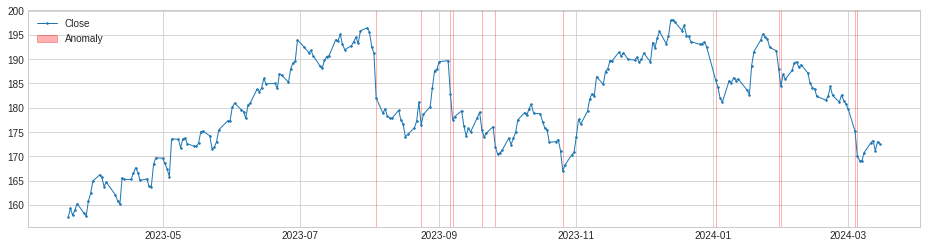

In [14]:
persist_ad = PersistAD(c=1.0, side='negative') #side can be positive or negative. Increasing c, which is the threshold
# will result in fewer points being identified as anamolous
anomalies = persist_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red')
plt.show()

Increasing the value of c, increases the threshold and will result in fewer points being identified as anomalous.


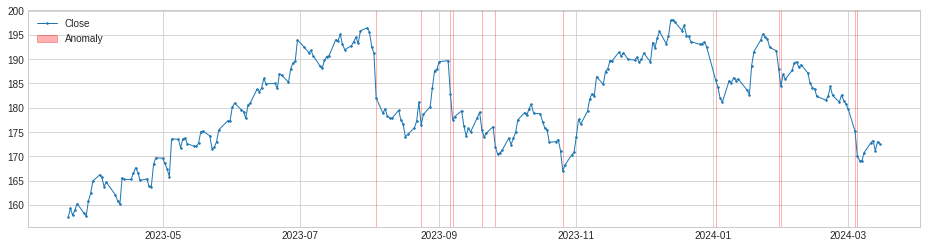

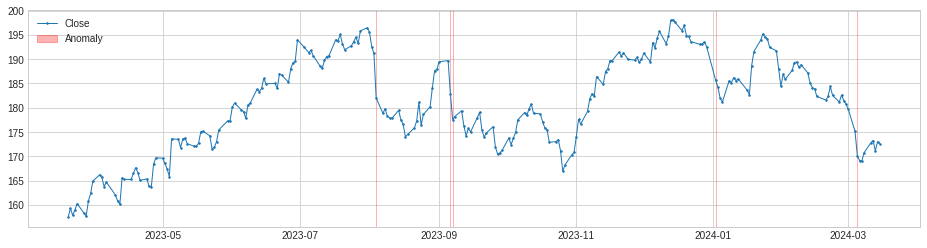

In [15]:
persist_ad = PersistAD(c=1.0, side='negative') #side can be positive or negative. Increasing c, which is the threshold
# will result in fewer points being identified as anamolous
anomalies = persist_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red')
plt.show()
persist_ad = PersistAD(c=2.0, side='negative') #side can be positive or negative. Increasing c, which is the threshold
# will result in fewer points being identified as anomalous
anomalies = persist_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red')
plt.show()

### ShiftAD

Next we will implment Level Shift AD. This model detects shift of value level by tracking the difference between median values at two sliding time windows next to each other. It is not sensitive to instantaneous spikes and could be a good choice if noisy outliers happen frequently.

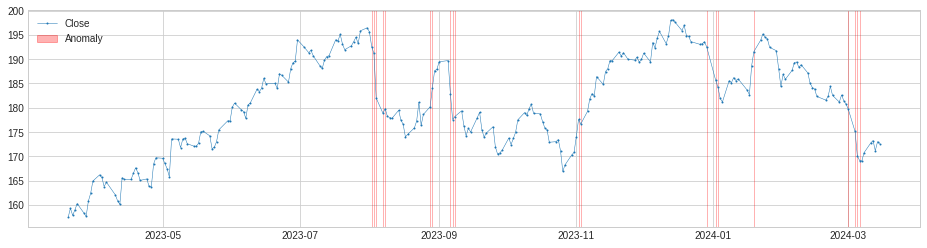

In [16]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=1.0, side='both', window=5)
anomalies = level_shift_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, anomaly_color='red')
plt.show()

As the chart shows, normal trends such as a continuous increase/decrease in closing price are not tagged as anomalous. However, a sudden shift from a previous upward or downward trends are. The window determines how far the in the past, in days, the model looks at before tagging a point as anomalous. Increasing the window is analogous to a smoothing process and will lead to a fewer set of points tagged as anomalies. Next we change the window from 5 to 10 and observe the stated outcome

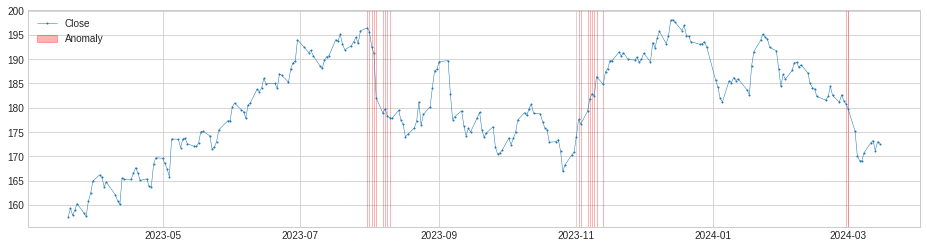

In [17]:
level_shift_ad = LevelShiftAD(c=1.0, side='both', window=10)
anomalies = level_shift_ad.fit_detect(df_closing)
plot(df_closing, anomaly=anomalies, anomaly_color='red')
plt.show()

The side='both' option can also be set to positive or negative, to track only positive spikes or negative drops.

### Volatility Shift AD

To track volatility in a time series we can use Volatility Shift AD. This model detects volatile shifts by tracking the difference between standard deviations at two sliding time windows, which are next to each other. The windows identify periods of time when the data points change consistently from the previous window. We will run this model on the trading volume data

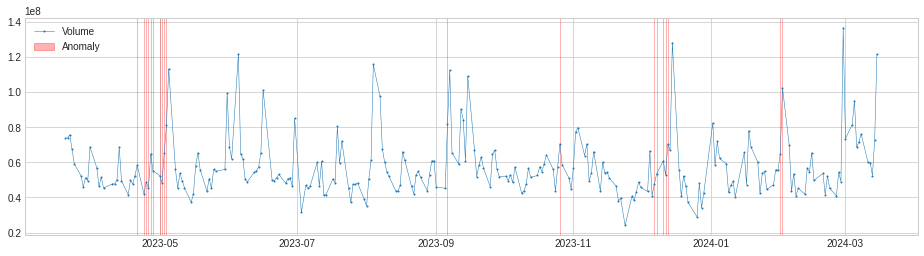

In [18]:
from adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=1.0, window=20)
anomalies = volatility_shift_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, anomaly_color='red')
plt.show()

Decreasing window can lead to more points identified as anomalous, we can think of this as decreasing the smoothing of the time series data. The effect of changing c is the same as for the other models

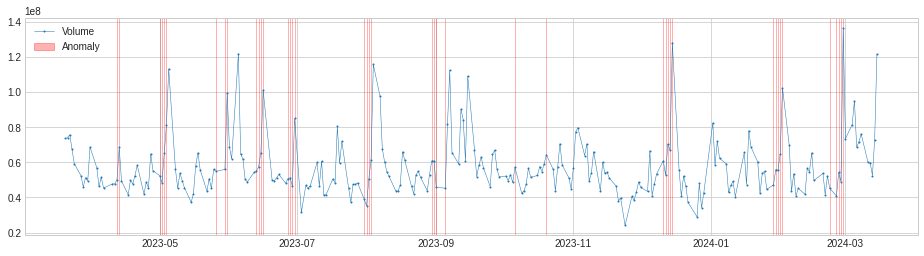

In [19]:
volatility_shift_ad = VolatilityShiftAD(c=1.0, window=5)
anomalies = volatility_shift_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, anomaly_color='red')
plt.show()

### Auto-Regression

We can also use auto-regression to identify changes in time series data. Autoregression is a statistical technique used in time-series analysis that assumes that the current value of a time series is a function of its past values.

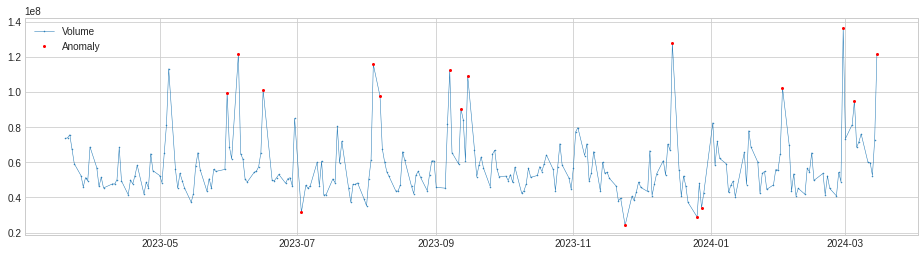

In [20]:
from adtk.detector import AutoregressionAD
autoregression_ad = AutoregressionAD(n_steps=10, step_size=5, c=1.0)
anomalies = autoregression_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2)
plt.show()

Again changing c effects the sensitivity of the test

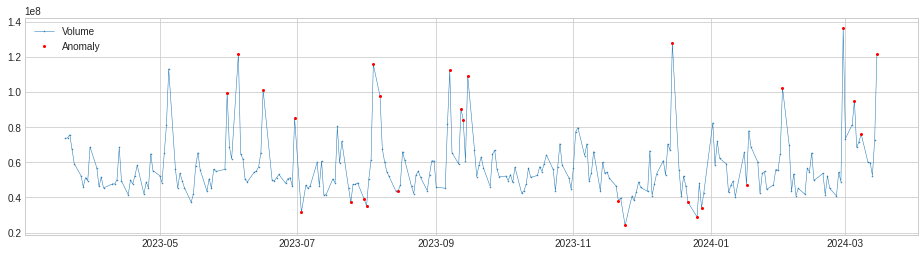

In [21]:
from adtk.detector import AutoregressionAD
autoregression_ad = AutoregressionAD(n_steps=10, step_size=5, c=0.5)
anomalies = autoregression_ad.fit_detect(df_volume)
plot(df_volume, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2)
plt.show()

n_steps determines the number of steps (previous values) to include in the model
step_size determines the length of a step. For example, if n_steps=2, step_size=3, X_[t-3] and X_[t-6] will be used to predict X_[t]

## Multivariate time series

We can also look at 2 time series of data (multi-variate time series) and see if anomalies exists based on them.
As an example we can take the closing stock prices on any given day and the volume of stock traded to analyze if there exists a relationship between the two. First lets place the data for the closing prices and volume into one dataframe object

In [22]:
df_close_volume = df[['Close','Volume']] #creating a new dataframe with closing price and volume data
df_close_volume

,Close,Volume
Date,,
2023-03-20,157.399994,73641400
2023-03-21,159.279999,73938300
2023-03-22,157.830002,75701800
2023-03-23,158.929993,67622100
2023-03-24,160.250000,59196500
...,...,...
2024-03-11,172.750000,60139500
2024-03-12,173.229996,59825400
2024-03-13,171.130005,52488700


Since the trading volume values are much larger than the close prices, we will need to divide the volume column for visualization purposes. This should not affect the models in any way since the models are looking at the relationship (ratios) between the datasets and not their absolute values.

In [23]:
df_close_volume['Volume']= df_close_volume['Volume'].div(1000000) #appropriate scale
df_close_volume

/tmp/ipykernel_1265/1700655241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close_volume['Volume']= df_close_volume['Volume'].div(1000000) #appropriate scale


,Close,Volume
Date,,
2023-03-20,157.399994,73.6414
2023-03-21,159.279999,73.9383
2023-03-22,157.830002,75.7018
2023-03-23,158.929993,67.6221
2023-03-24,160.250000,59.1965
...,...,...
2024-03-11,172.750000,60.1395
2024-03-12,173.229996,59.8254
2024-03-13,171.130005,52.4887


### MinClusterDetector

We can then use a clustering algorithm, such as k-means to identify clusters of points
where the closing price and volume change together in an unexpected manner

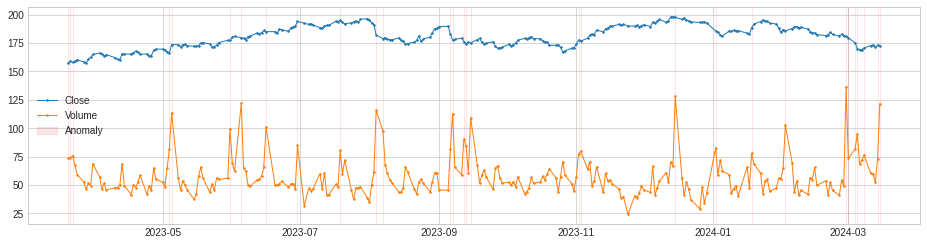

In [24]:
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=2)) #increasing the clusters increases the number of anomalous points
anomalies = min_cluster_detector.fit_detect(df_close_volume)
plot(df_close_volume, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.1, curve_group='all')
plt.show()

The points marked as anomalous indicate large changes in volume or price that did not lead to a correspondingly large enough change in the other variable

### Regression

We can also use regression to identify anomalies in multi-variate time series

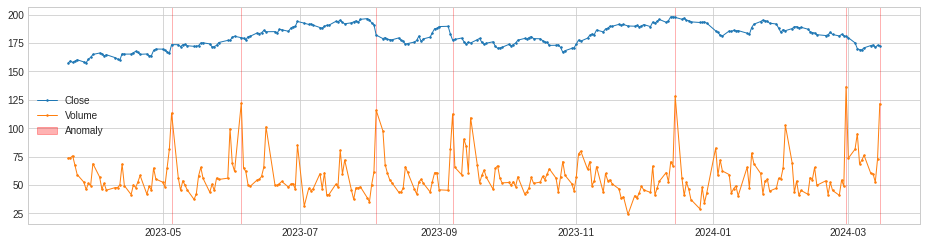

In [25]:
from adtk.detector import RegressionAD
from sklearn.linear_model import LinearRegression
regression_ad = RegressionAD(regressor=LinearRegression(), target="Volume", c=4.0)
anomalies = regression_ad.fit_detect(df_close_volume)
plot(df_close_volume, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')
plt.show()

Again the points marked as anomalous indicate large changes in volume or price that did not lead to a correspondingly large enough change in the other variable

## Next Steps

In this module we have covered how to load, store, and visualize time series data. We also went over the implementation of a variety of methods/models to identify anomalies them. 

Though this module serves as a primer and uses stock price and volume data as example, the methods/models detailed are transferable and applicable to any type of time series, including those pertinent to supervision such as anti-money laundering and fraudulent transactions.
